# Mount GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Buka direktori dataset di gdrive

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Bangkit 2024 Batch 1 remove BG')

# Prepocessing

In [ ]:
folder_path = ('/content/drive/MyDrive/Bangkit 2024 Batch 1 remove BG/Healthy')
test = os.listdir(folder_path)
for data in test:
    if not(data.endswith(".jpg")):
        os.remove(os.path.join(folder_path, data))

In [ ]:
folder_path = ('/content/drive/MyDrive/Bangkit 2024 Batch 1 remove BG/Miner')
test = os.listdir(folder_path)
for data in test:
    if not(data.endswith(".jpg")):
        os.remove(os.path.join(folder_path, data))

In [ ]:
folder_path = ('/content/drive/MyDrive/Bangkit 2024 Batch 1 remove BG/Phoma')
test = os.listdir(folder_path)
for data in test:
    if not(data.endswith(".jpg")):
        os.remove(os.path.join(folder_path, data))

In [ ]:
folder_path = ('/content/drive/MyDrive/Bangkit 2024 Batch 1 remove BG/Rust')
test = os.listdir(folder_path)
for data in test:
    if not(data.endswith(".jpg")):
        os.remove(os.path.join(folder_path, data))

In [ ]:
#cek label
from pathlib import Path
image_dir = Path('/content/drive/MyDrive/Bangkit 2024 Batch 1 remove BG')

filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [ ]:
import pandas as pd
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/Bangkit 2024 Batch 1 re...,Healthy
1,/content/drive/MyDrive/Bangkit 2024 Batch 1 re...,Phoma
2,/content/drive/MyDrive/Bangkit 2024 Batch 1 re...,Miner
3,/content/drive/MyDrive/Bangkit 2024 Batch 1 re...,Rust
4,/content/drive/MyDrive/Bangkit 2024 Batch 1 re...,Healthy


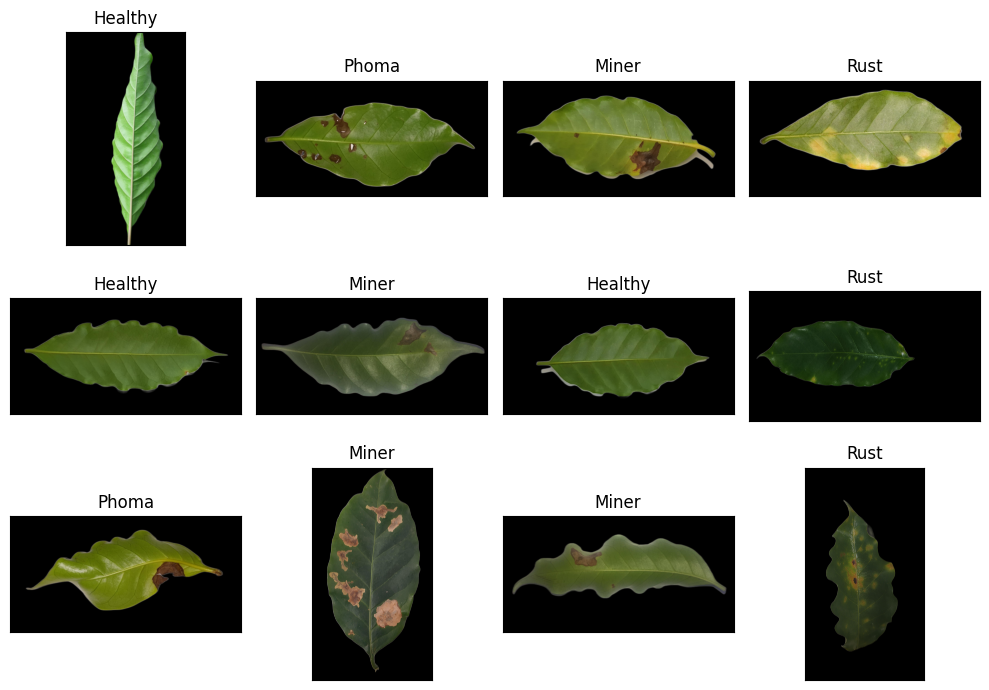

In [ ]:
# Display some pictures of the dataset with their labels
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

<ipython-input-10-e619146533d5>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = vc.index, y = vc, palette = "rocket")


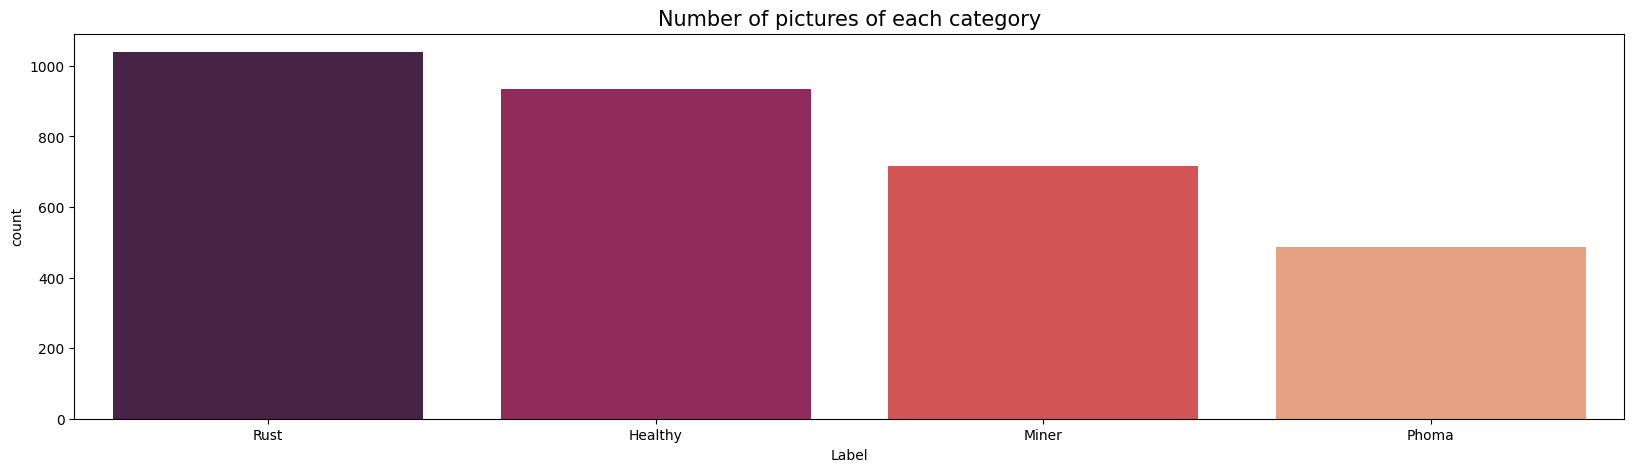

In [ ]:

# Display the number of pictures of each category
import seaborn as sns
vc = image_df['Label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [ ]:
#Shuffle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# Separate in train and test data
train_df, validasi_df = train_test_split(image_df, train_size=0.8, shuffle=True, random_state=1)

In [ ]:
#data generator
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_dataframe(dataframe=train_df,
                                          x_col='Filepath',
                                          y_col='Label',
                                         seed=0,
                                         target_size=(224,224),
                                         batch_size=32,
                                         shuffle=True,
                                         class_mode = 'categorical',
                                        subset='training',
                                         )

validasi_data = val_datagen.flow_from_dataframe(dataframe=validasi_df,
                                        x_col='Filepath',
                                        y_col='Label',
                                         seed=0,
                                         target_size=(224,224),
                                         batch_size=32,
                                         shuffle=False,
                                         class_mode = 'categorical',
                                         )

Found 2541 validated image filenames belonging to 4 classes.
Found 636 validated image filenames belonging to 4 classes.


# Built Inception

In [ ]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-05-30 14:48:23--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.207, 142.250.107.207, 173.194.202.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   149MB/s    in 0.6s    

2024-05-30 14:48:24 (149 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
from keras import Model, Input
input_shape = (224,224,3)
model_input = Input(shape=input_shape)

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (224, 224, 3),
                                include_top = False,
                                input_tensor=model_input,
                                weights = "imagenet")

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = True

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalizati

In [ ]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 5, 5, 2048)


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (4, activation='softmax')(x)

# Append the dense network to the base model
inception = Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
inception.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [ ]:
import tensorflow as tf
from keras.callbacks import EarlyStopping
class EarlyStoppingAtMaxAccuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if(logs.get('val_accuracy')>=0.99):
            print("\nAccuracy is high so cancelling training!")
            self.model.stop_training = True
callbacks = EarlyStoppingAtMaxAccuracy()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Tentukan path penyimpanan model
checkpoint_path = '/content/drive/MyDrive/ens2_inception/inception.h5'

# Buat callback ModelCheckpoint
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      monitor='val_loss',  # Metrik yang akan dipantau
                                      save_best_only=True,  # Hanya menyimpan model terbaik
                                      save_weights_only=False,  # Menyimpan seluruh model
                                      mode='min',  # Mode pemantauan (misalnya, 'min', 'max', atau 'auto')
                                      verbose=1)  # Menampilkan pesan saat menyimpan

In [ ]:

# # Set the training parameters
# callbacks= myCallback()
inception.compile(optimizer = Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
history_inception = inception.fit(
                  train_data,
                  batch_size=32,
                  validation_data=validasi_data,
                  epochs=30, callbacks=([callbacks],[checkpoint_callback]))

Epoch 1/30
80/80 [==============================] - ETA: 0s - loss: 0.8901 - accuracy: 0.7328 
Epoch 1: val_loss improved from inf to 0.60464, saving model to /content/drive/MyDrive/ens2_inception/inception.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


80/80 [==============================] - 1453s 18s/step - loss: 0.8901 - accuracy: 0.7328 - val_loss: 0.6046 - val_accuracy: 0.8475
Epoch 2/30
80/80 [==============================] - ETA: 0s - loss: 0.2499 - accuracy: 0.9154
Epoch 2: val_loss improved from 0.60464 to 0.25697, saving model to /content/drive/MyDrive/ens2_inception/inception.h5
80/80 [==============================] - 113s 1s/step - loss: 0.2499 - accuracy: 0.9154 - val_loss: 0.2570 - val_accuracy: 0.9167
Epoch 3/30
80/80 [==============================] - ETA: 0s - loss: 0.1819 - accuracy: 0.9359
Epoch 3: val_loss improved from 0.25697 to 0.12520, saving model to /content/drive/MyDrive/ens2_inception/inception.h5
80/80 [==============================] - 107s 1s/step - loss: 0.1819 - accuracy: 0.9359 - val_loss: 0.1252 - val_accuracy: 0.9638
Epoch 4/30
80/80 [==============================] - ETA: 0s - loss: 0.1291 - accuracy: 0.9547
Epoch 4: val_loss improved from 0.12520 to 0.12282, saving model to /content/drive/MyDri

# Saved Model to .h5

In [ ]:
MODEL_BASE_PATH = "/content/drive/MyDrive/ens2_inception/"
PROJECT_NAME = "H5"
SAVE_MODEL_NAME = "ens_inceptionv_20epoch_1024.1.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)
if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))

print('Saving Model At {}...'.format(save_model_path))
inception.save(save_model_path,include_optimizer=False)

Saving Model At /content/drive/MyDrive/ens2_inception/H5/ens_inceptionv_20epoch_1024.1.h5...


In [ ]:
inception.evaluate(validasi_data)

20/20 [==============================] - 12s 568ms/step - loss: 0.0737 - accuracy: 0.9906


[0.07367277145385742, 0.9905660152435303]

# Plotting Accuration After Training and Test Model

In [ ]:
#plotting
import matplotlib.pyplot as plt
def display_training_curves(training, validation, title, subplot):

    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(6,8), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

<ipython-input-30-640e4c0dc1bc>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


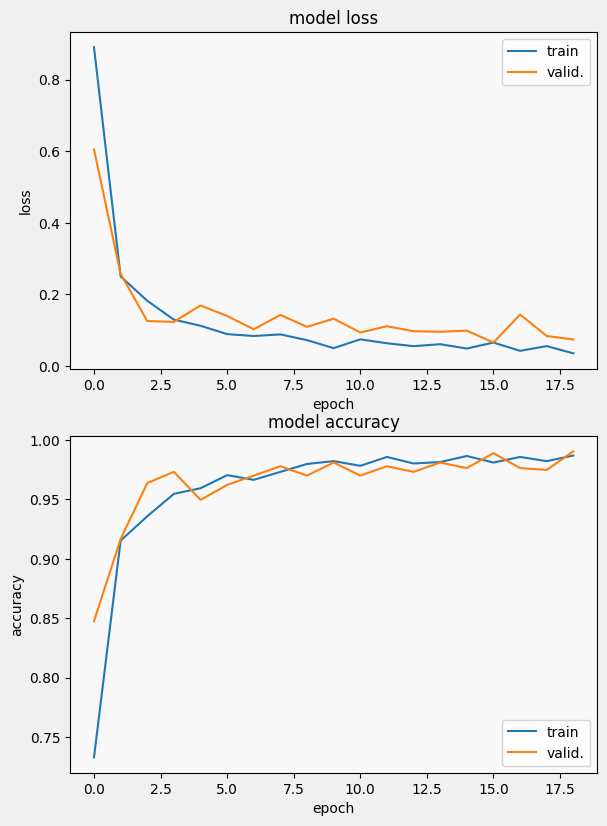

In [ ]:
#display
display_training_curves(
    history_inception.history['loss'],
    history_inception.history['val_loss'],
    'loss', 211)
display_training_curves(
    history_inception.history['accuracy'],
    history_inception.history['val_accuracy'],
    'accuracy', 212)

In [ ]:
# Predict the label of the test_images
import numpy as np
pred = inception.predict(validasi_data)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:4]}')

20/20 [==============================] - 13s 561ms/step
The first 5 predictions: ['Phoma', 'Miner', 'Rust', 'Healthy']


In [ ]:
#classification Report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_test = list(validasi_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

     Healthy       0.98      0.99      0.99       192
       Miner       0.99      1.00      1.00       141
       Phoma       1.00      1.00      1.00       106
        Rust       0.99      0.98      0.98       197

    accuracy                           0.99       636
   macro avg       0.99      0.99      0.99       636
weighted avg       0.99      0.99      0.99       636



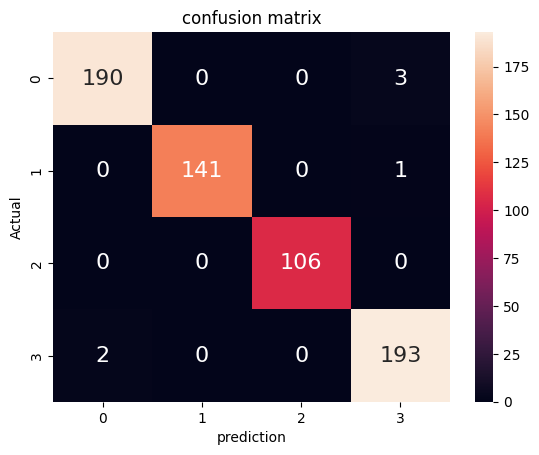

In [ ]:
import seaborn as sns
import pandas as pd
cm  = confusion_matrix(pred,y_test)
df_cm = pd.DataFrame(cm, index = [i for i in range(4)],
                  columns = [i for i in range(4)])
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d')
plt.title('confusion matrix')
plt.xlabel('prediction')
plt.ylabel('Actual');

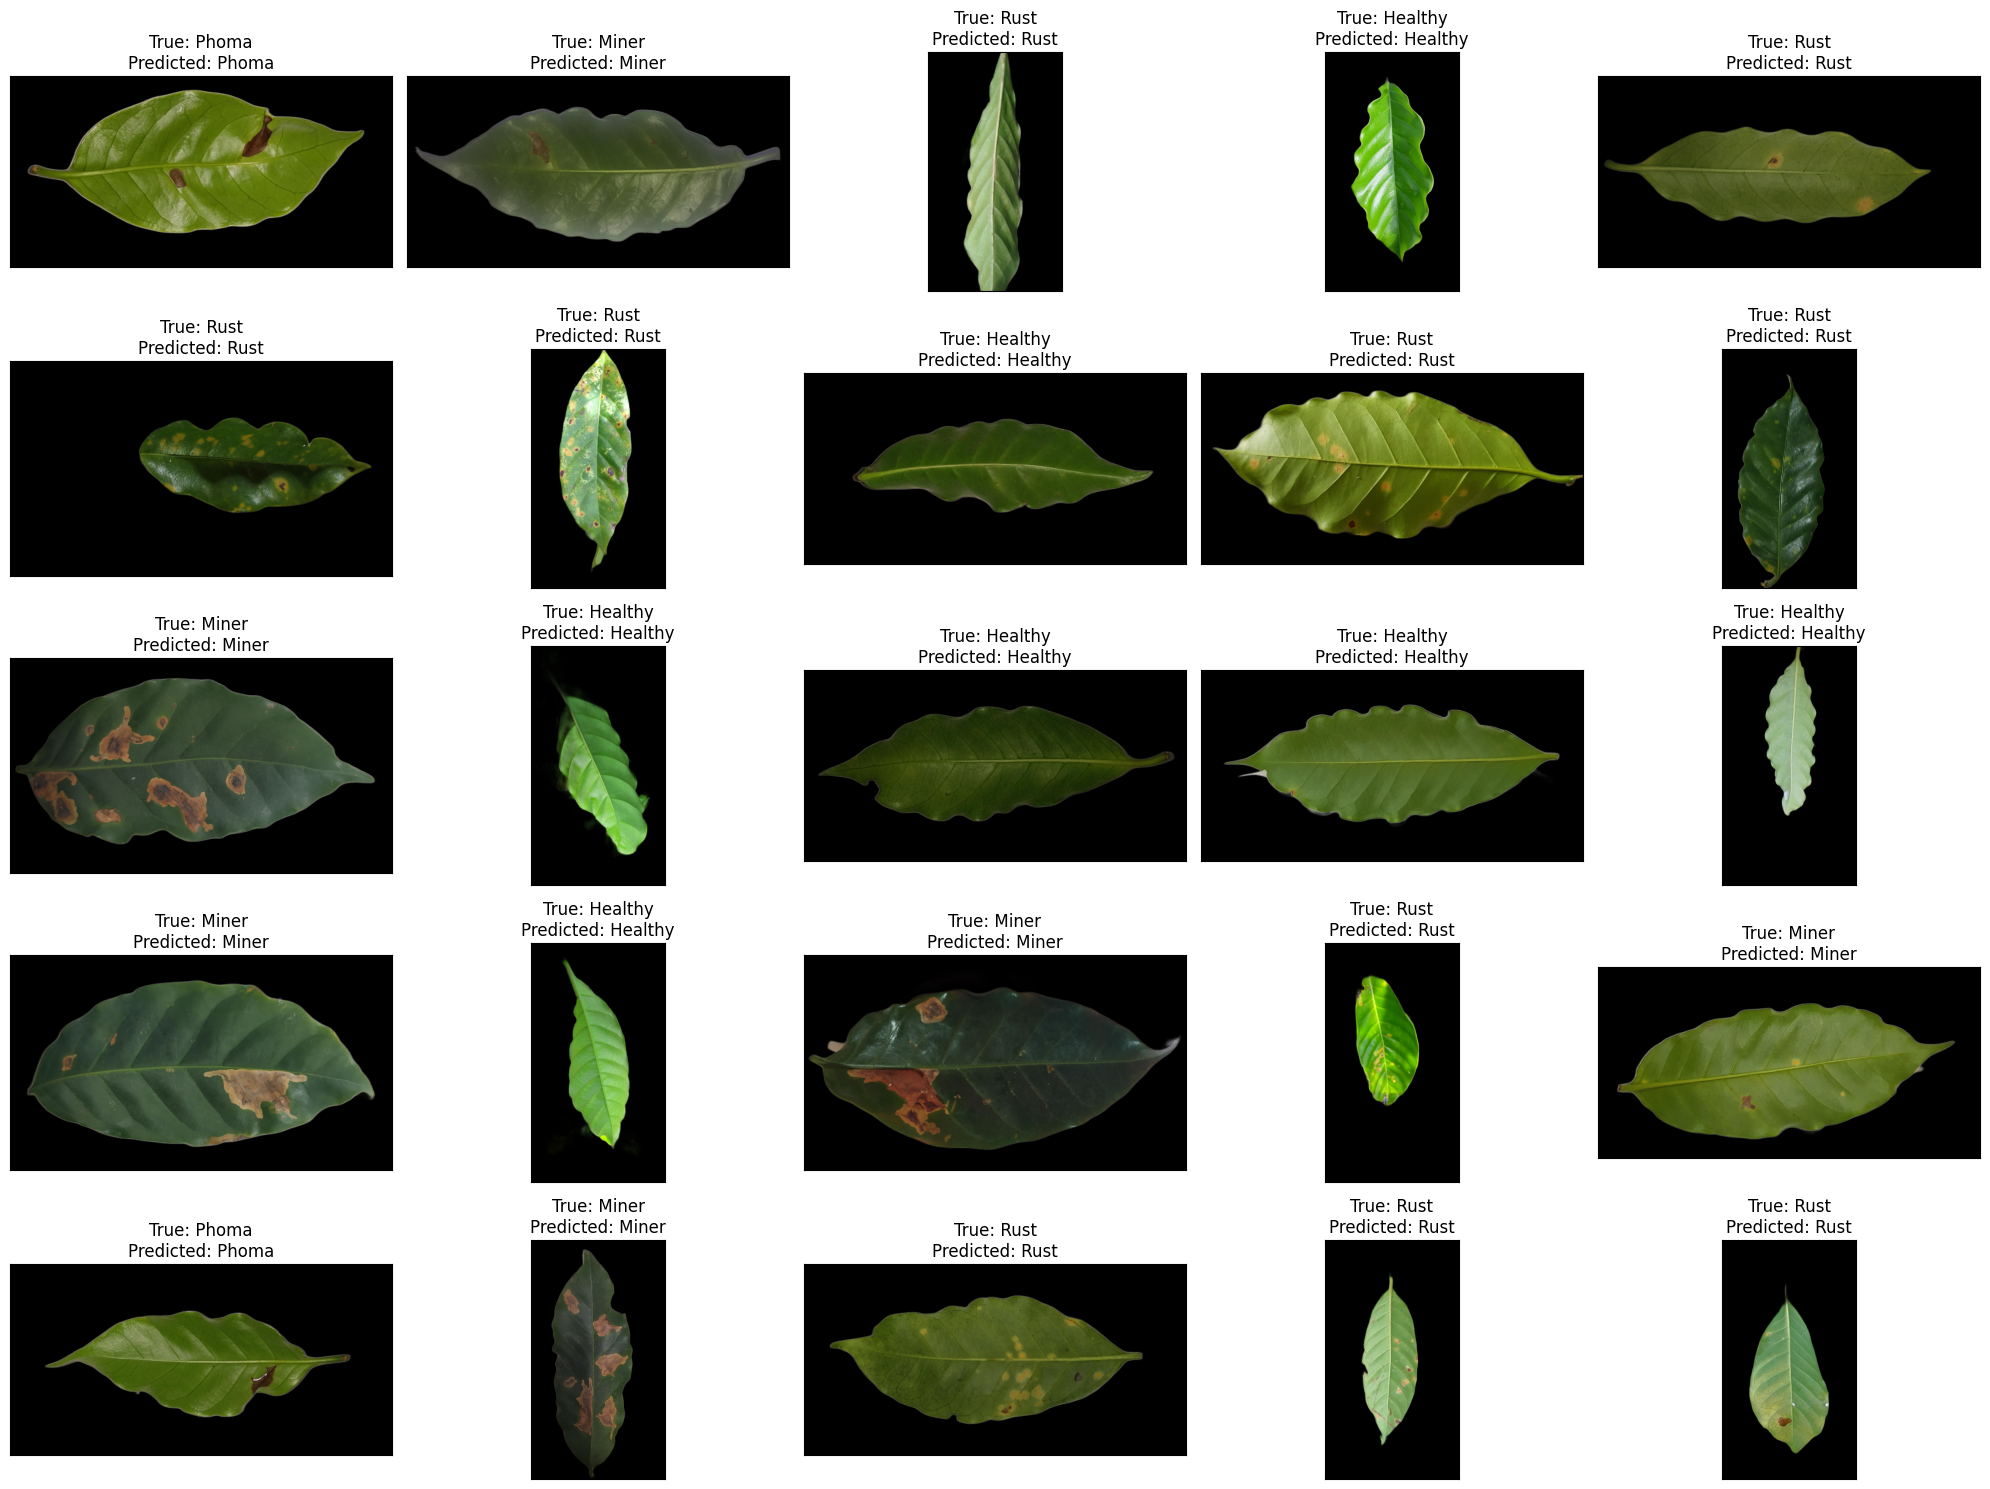

In [ ]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(validasi_df.Filepath.iloc[i]))
    ax.set_title(f"True: {validasi_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()